Processing subject 1, trial 1


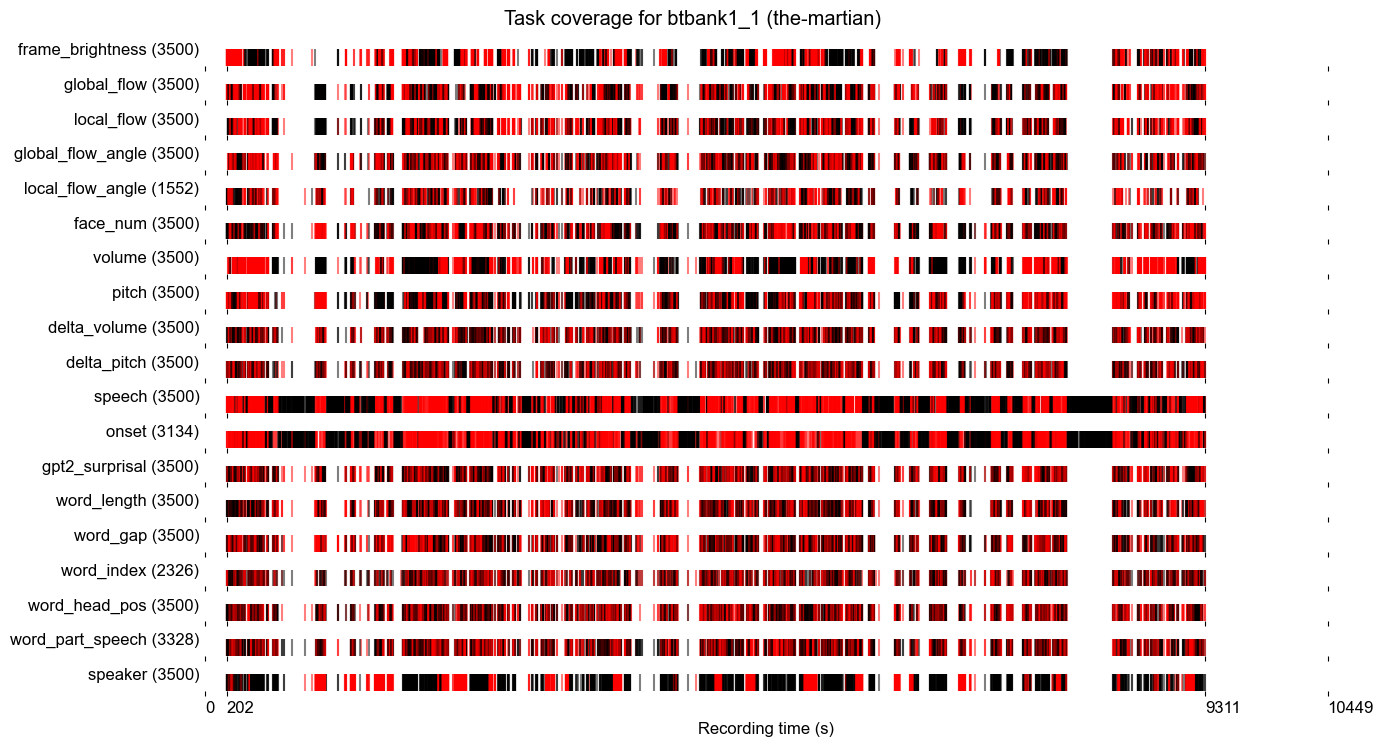

Processing subject 1, trial 2


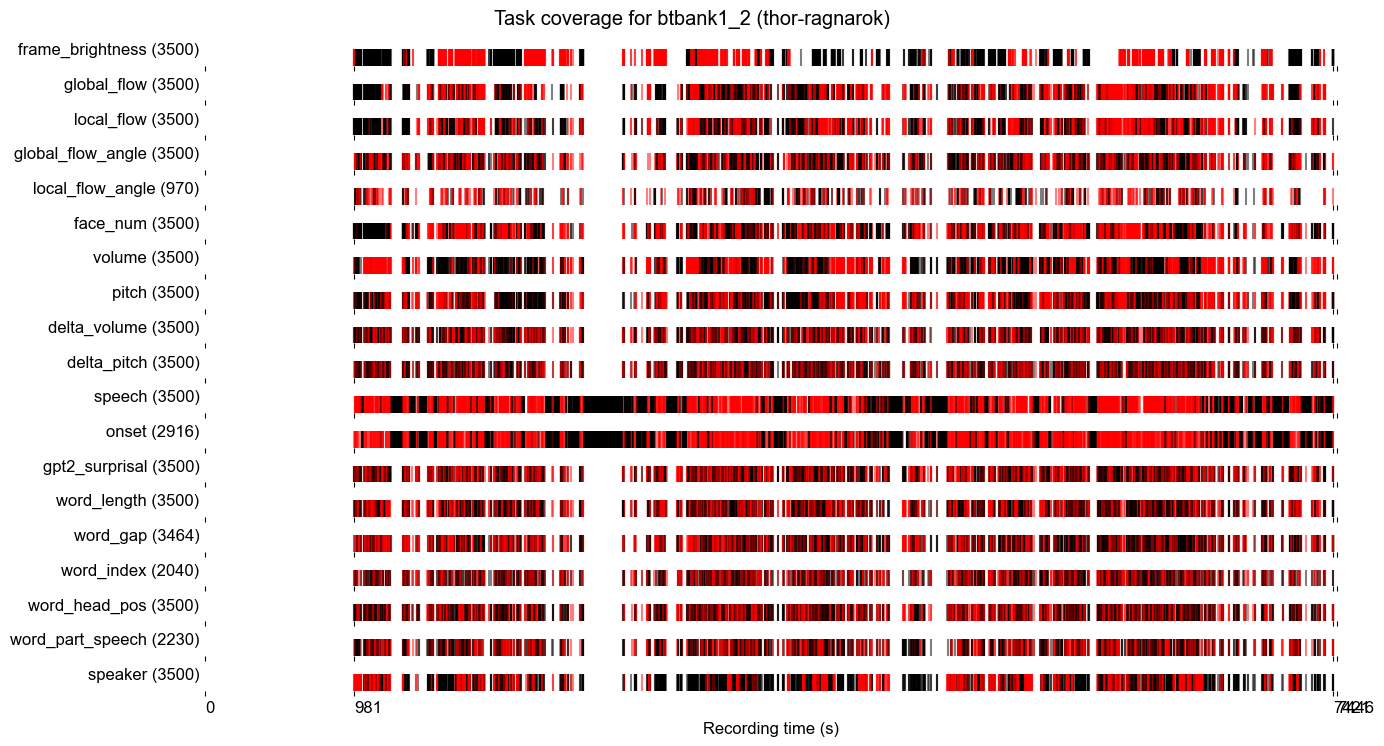

Processing subject 2, trial 0


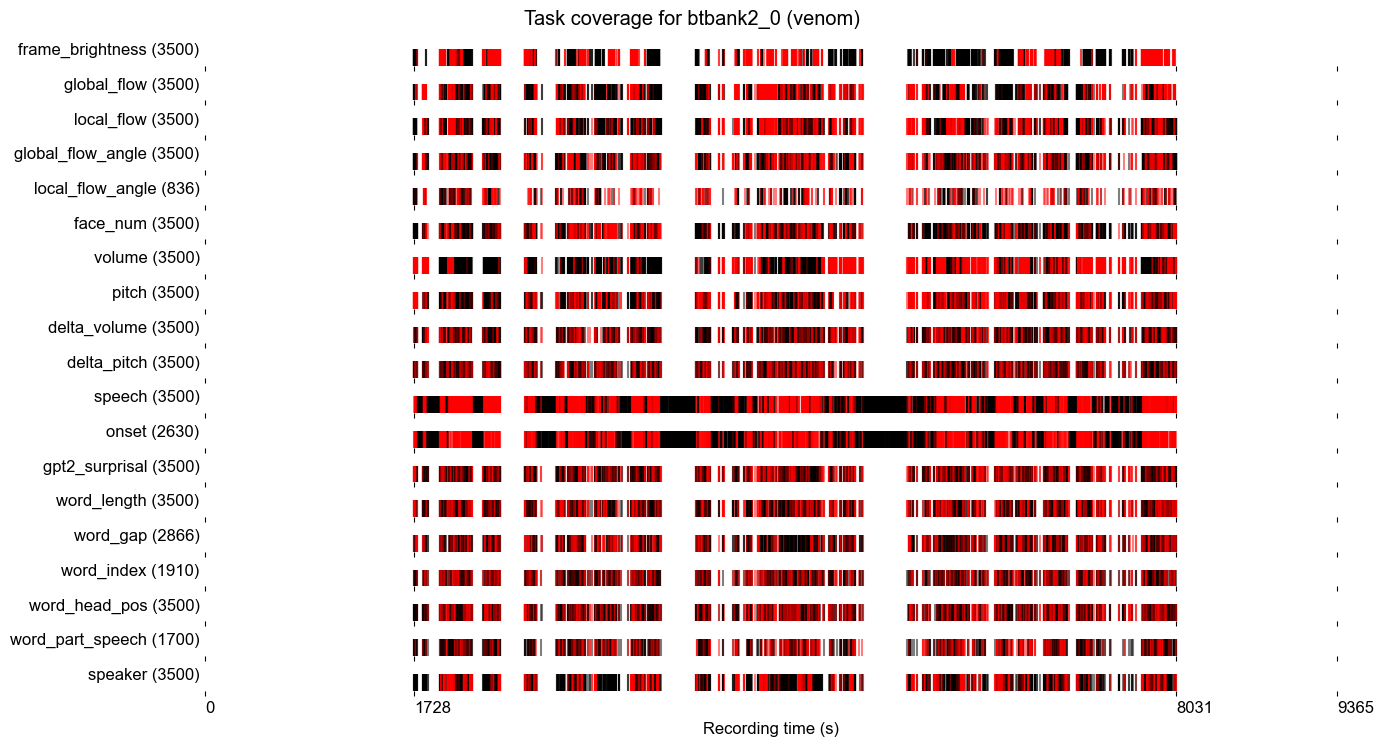

Processing subject 2, trial 4


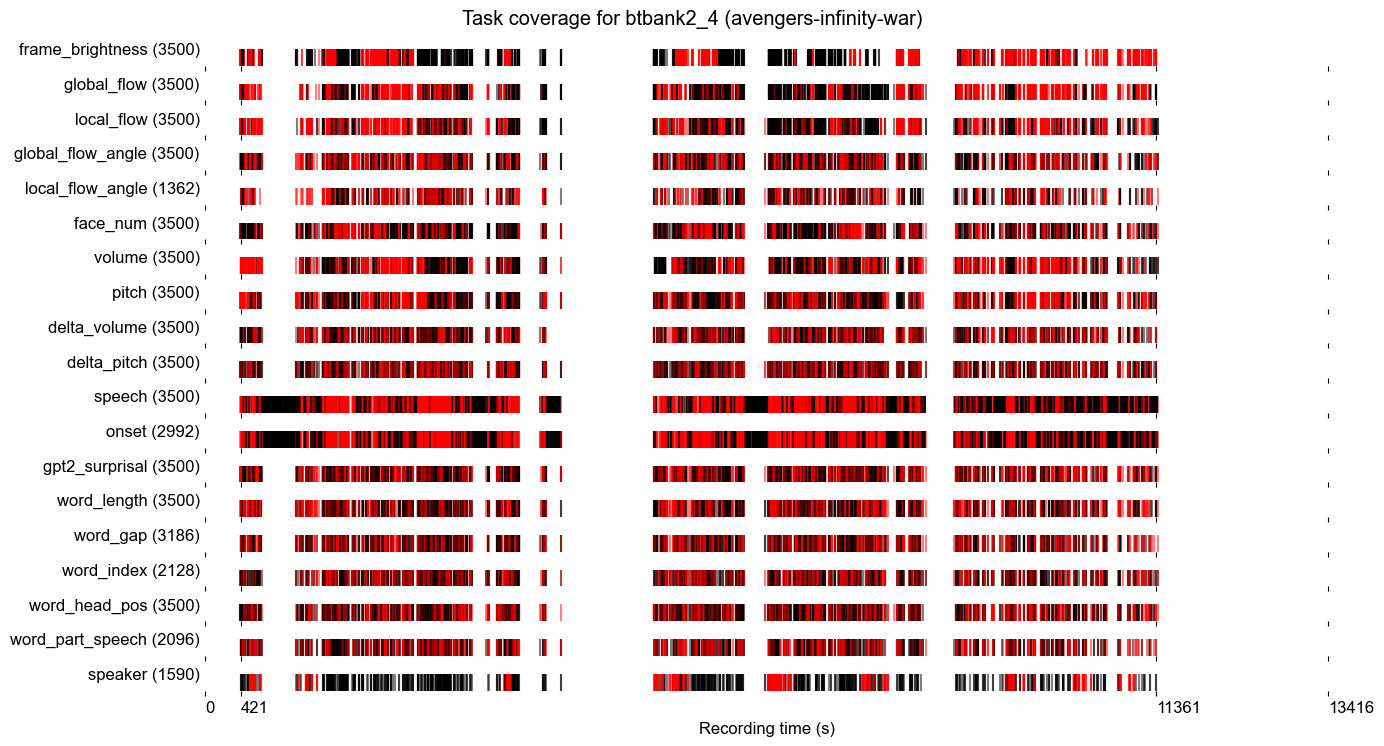

Processing subject 3, trial 0


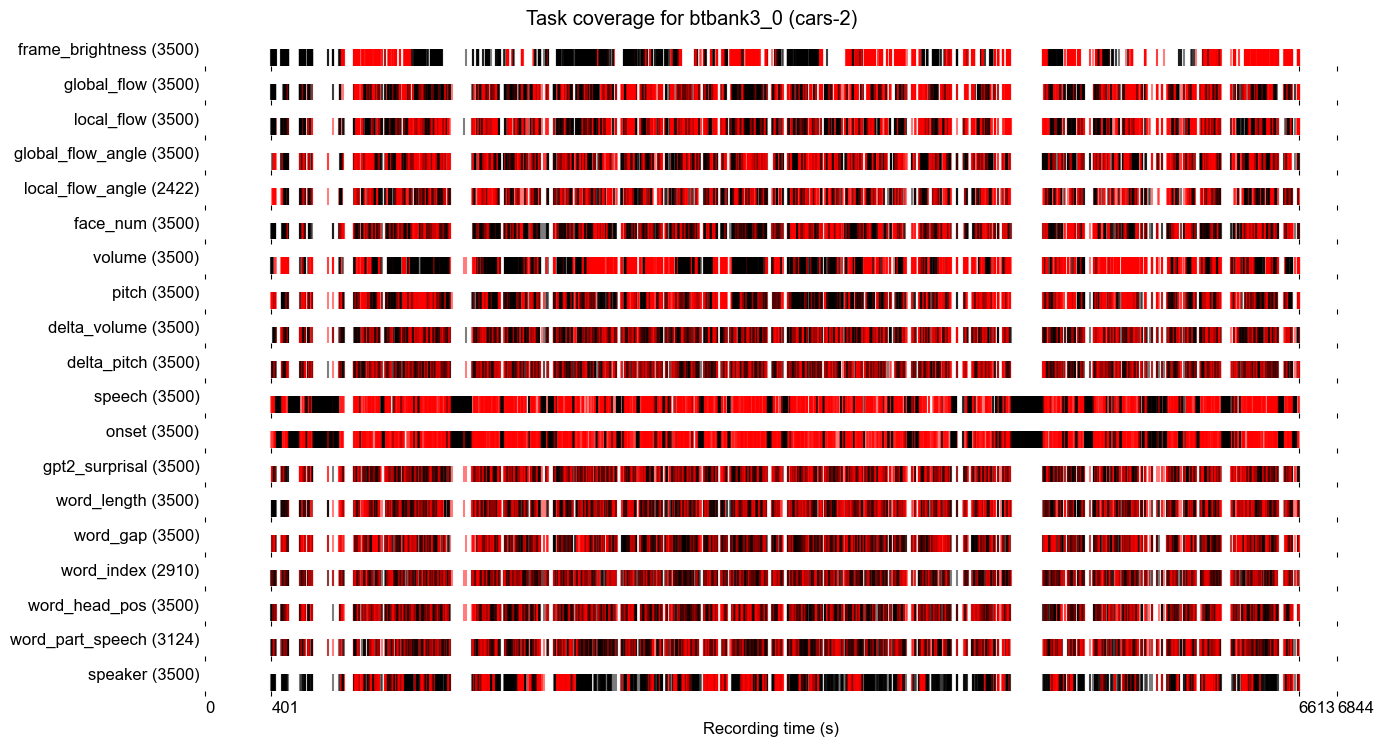

Processing subject 3, trial 1


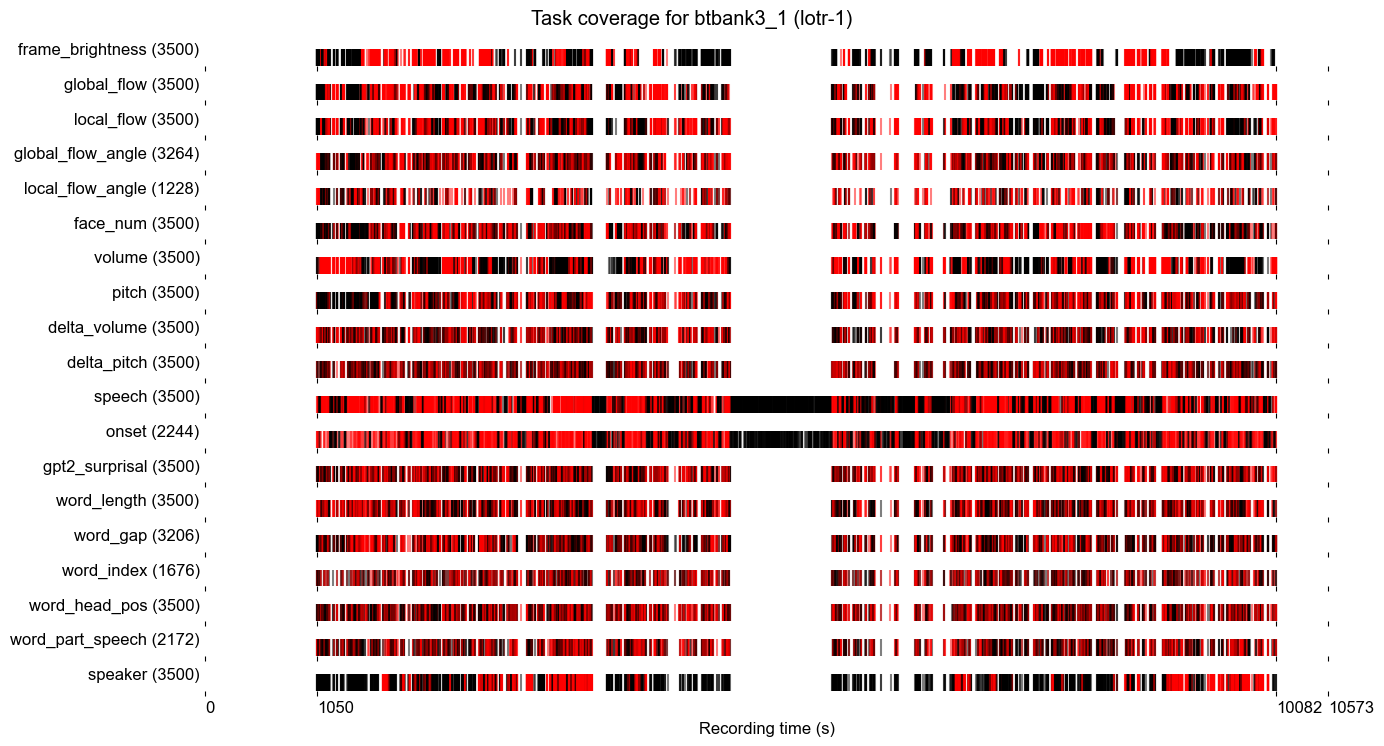

Processing subject 4, trial 0


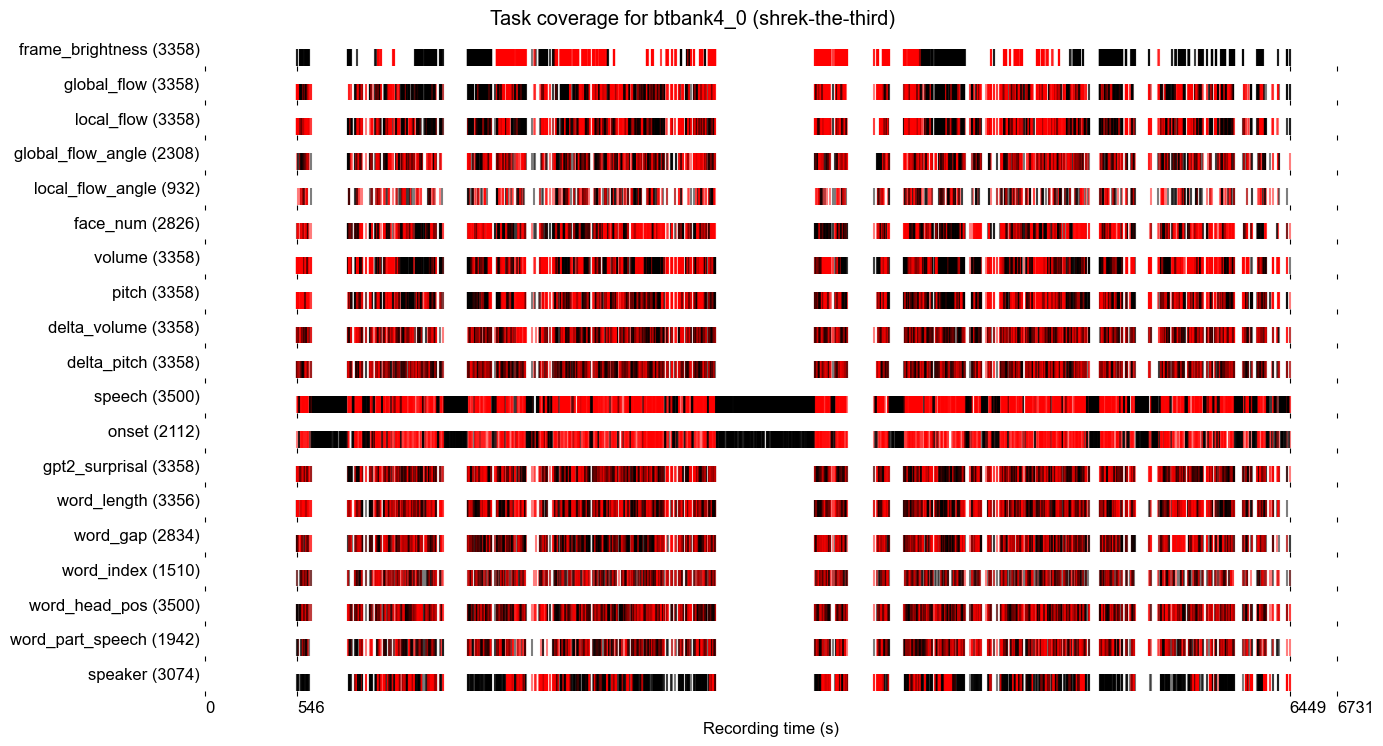

Processing subject 4, trial 1


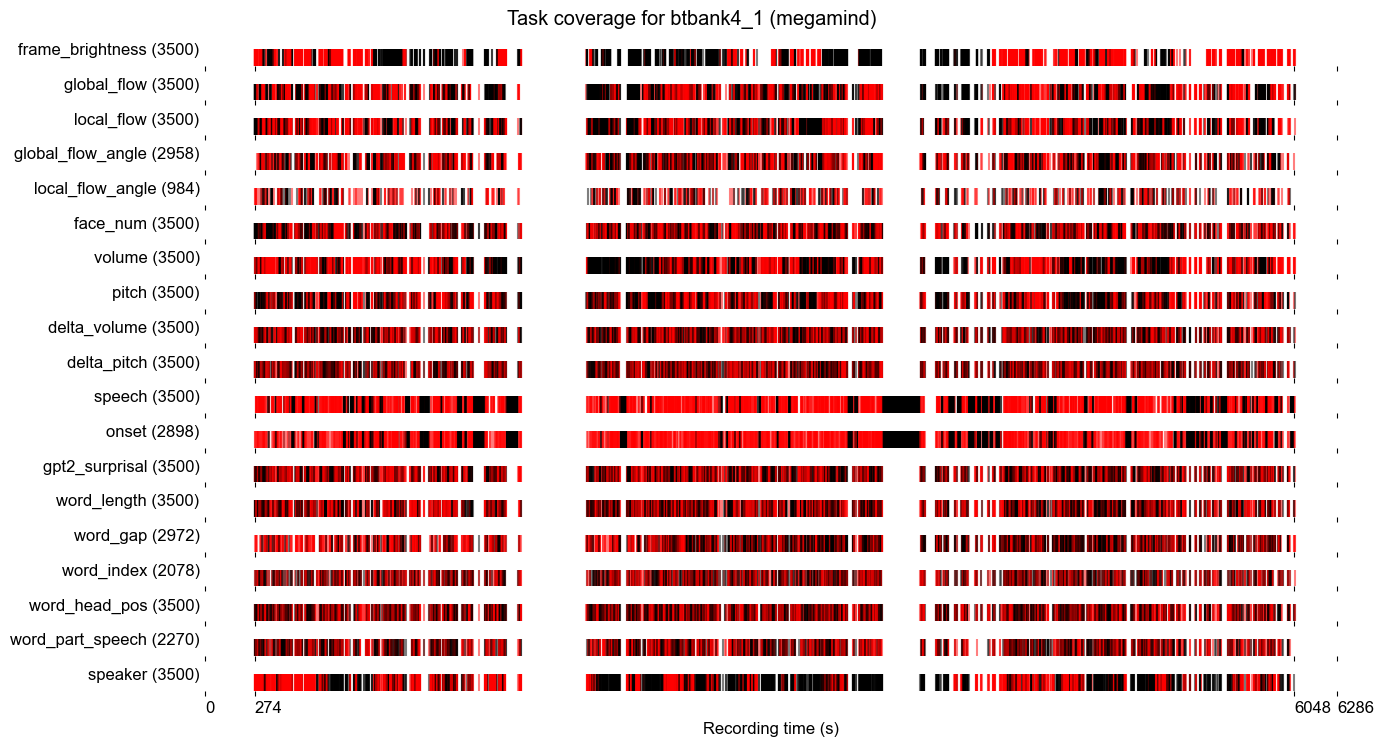

Processing subject 7, trial 0


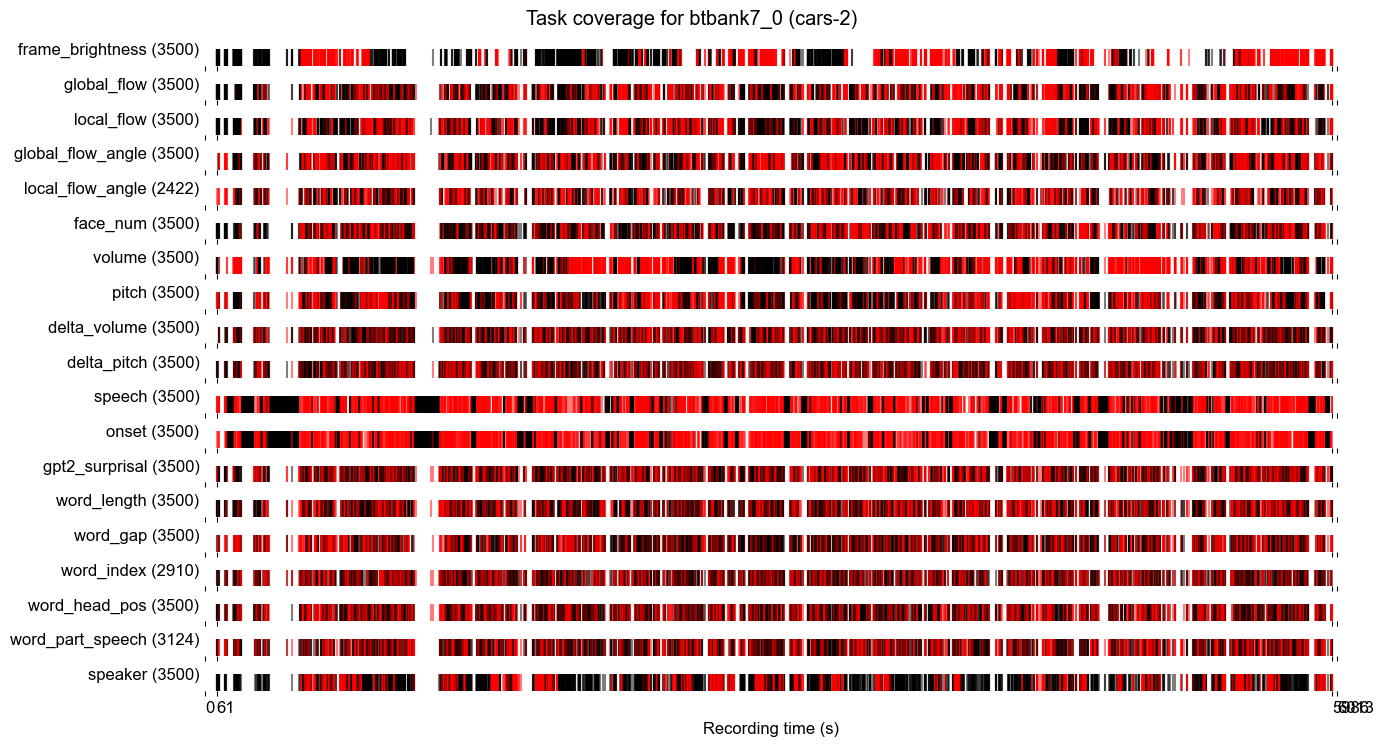

Processing subject 7, trial 1


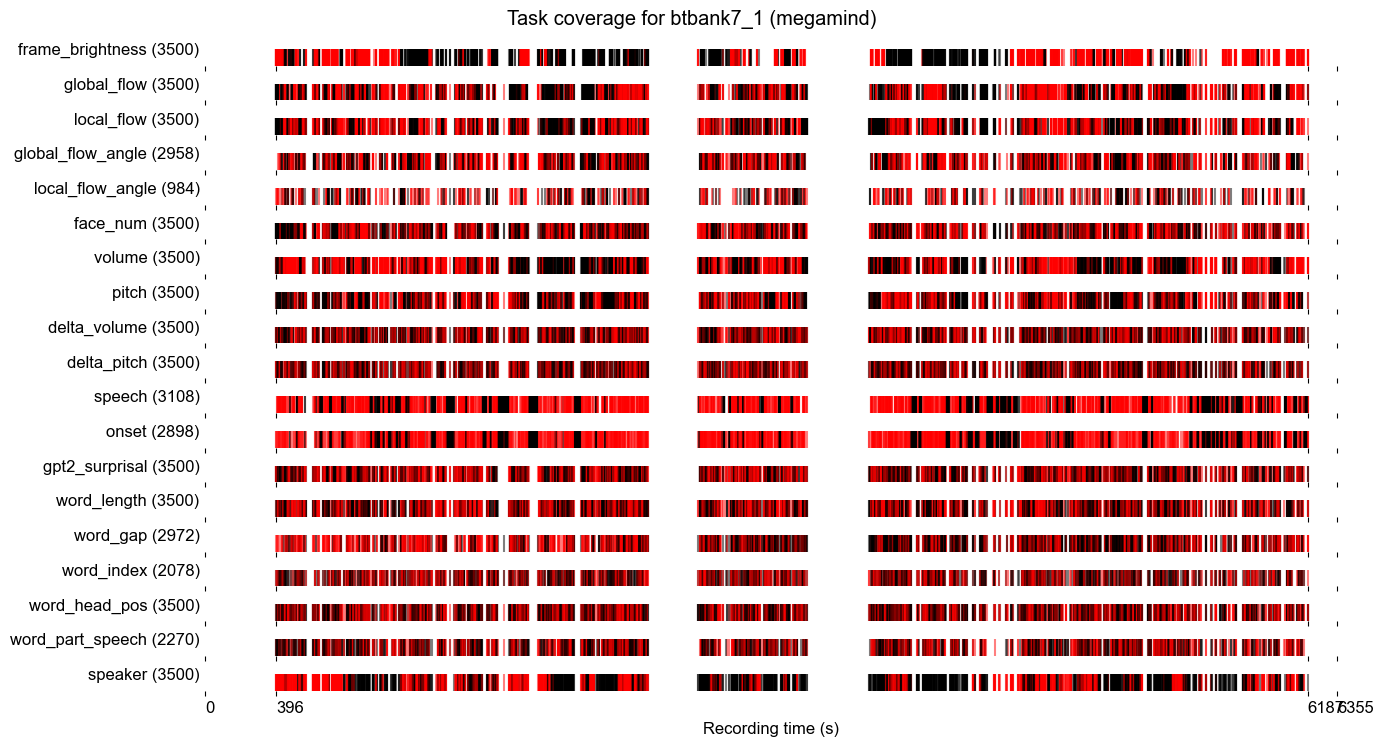

Processing subject 10, trial 0


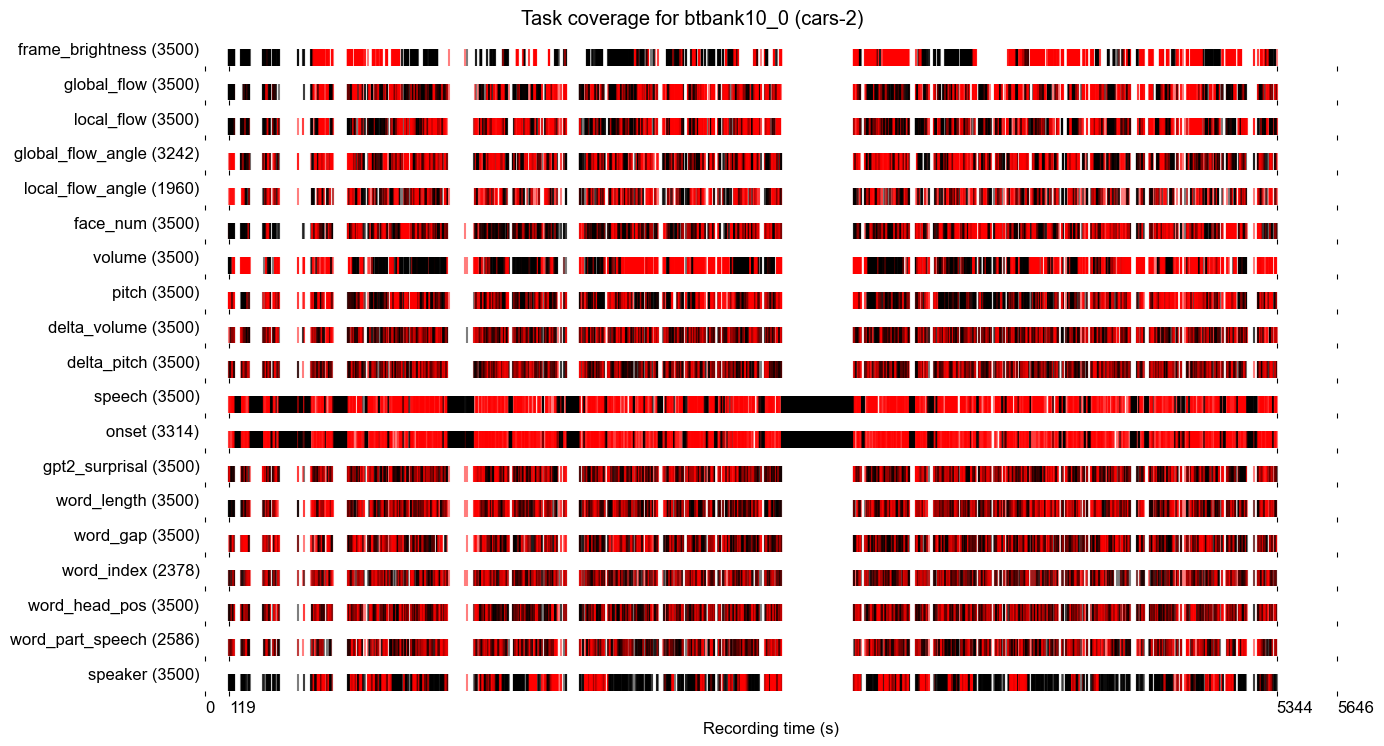

Processing subject 10, trial 1


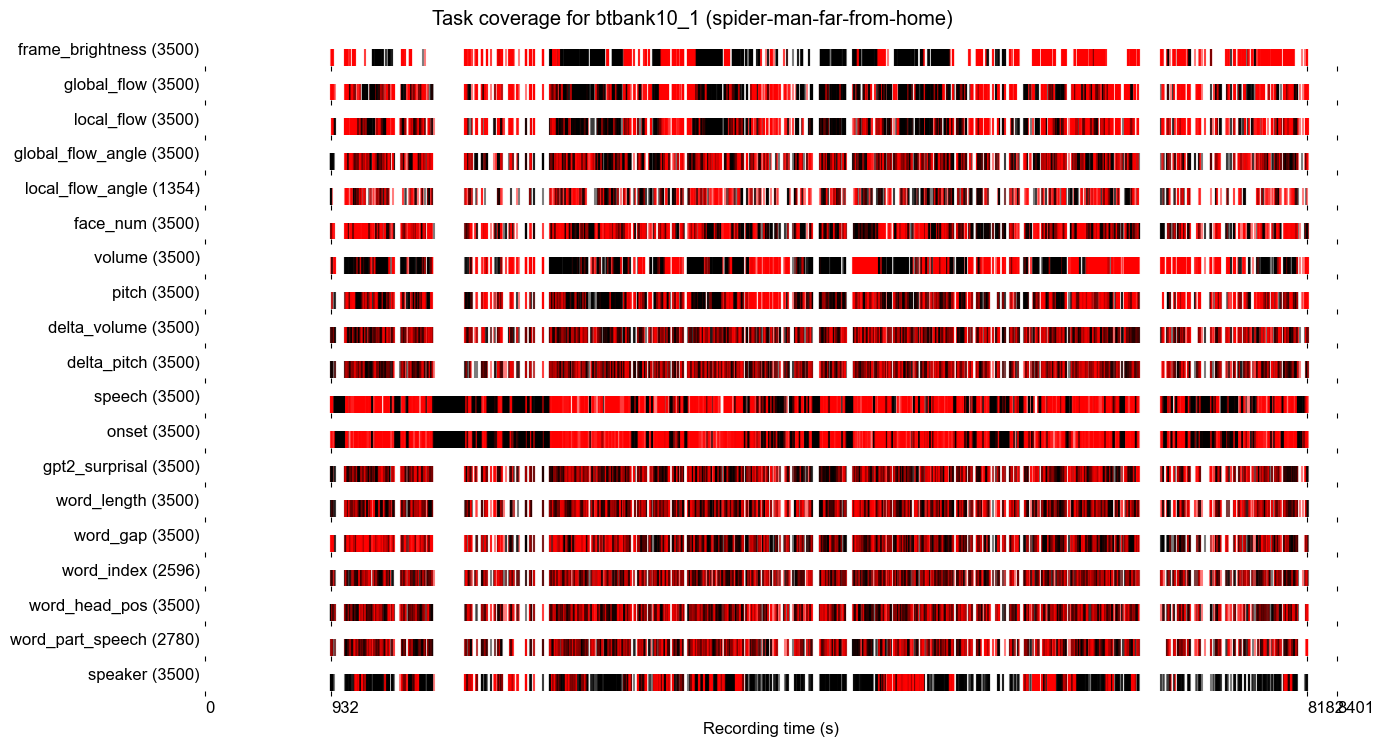

In [1]:
import torch
import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np
import matplotlib.pyplot as plt
import os

# Add Arial font
import matplotlib.font_manager as fm
font_path = 'assets/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


def plot_task_coverage(session_key, session_data, show=True):
    session_length = session_data['session_length']
    tasks = {task: session_data['tasks'][task] for task in session_data['tasks'] if not task.endswith('_label')}
    n_tasks = len(tasks)
    
    # Create figure with n_tasks rows
    fig, axes = plt.subplots(n_tasks, 1, figsize=(14, n_tasks*0.4), sharex=True)
    movie_name = neuroprobe_config.BRAINTREEBANK_SUBJECT_TRIAL_MOVIE_NAME_MAPPING[session_key]
    # Plot each task's points
    for i, (task_name, points) in enumerate(tasks.items()):
            
        ax = axes[i]
        labels = session_data['tasks'][task_name + "_label"]
        # Combine all points and labels into arrays
        all_points = np.array(points)
        all_labels = np.array(labels)
        
        # Generate random permutation indices
        rand_idx = np.random.permutation(len(all_points))
        # Randomize points and labels using same permutation
        all_points = all_points[rand_idx]
        all_labels = all_labels[rand_idx]
        # Plot randomized points in one scatter call
        colors = ['black' if l == 0 else 'red' for l in all_labels]
        ax.scatter(all_points, [0]*len(all_points), marker='|', s=200, c=colors, alpha=0.5)
        
        # Set ylabel with task name and number of datapoints
        ax.set_ylabel(f'{task_name} ({len(points)})', rotation=0, ha='right')
        ax.set_yticks([])
        ax.set_ylim(-0.1, 0.1)

        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Only show x-axis on bottom subplot
        if i == n_tasks-1:
            ax.set_xlabel('Recording time (s)')
            # Add ticks for min, max and endpoints
            min_point = min(points)
            max_point = max(points)
            ax.set_xticks([0, min_point, max_point, session_length], 
                         labels=[0, int(min_point/2048), int(max_point/2048), int(session_length/2048)],
                         ha='left')
        
        # Set consistent x limits
        ax.set_xlim(0, session_length)
    
    fig.suptitle(f'Task coverage for {session_key} ({movie_name})')
        
    plt.tight_layout()
    # Create directory if it doesn't exist
    os.makedirs('analyses/task_coverage_of_sessions', exist_ok=True)
    
    # Save figure with bbox_inches='tight'
    fig.savefig(f'analyses/task_coverage_of_sessions/{session_key}_{movie_name}.pdf', bbox_inches='tight')
    plt.show()


coverage_dict = {}
for (subject_id, trial_id) in neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS:
    print(f"Processing subject {subject_id}, trial {trial_id}")
    subject = BrainTreebankSubject(subject_id, allow_corrupted=False, cache=False, dtype=torch.float32)
    subject.load_neural_data(trial_id)
    
    st_string = f"btbank{subject_id}_{trial_id}"
    coverage_dict[st_string] = {
        "session_length": subject.electrode_data_length[trial_id],
        "tasks": {}
    }

    for task in neuroprobe_config.NEUROPROBE_TASKS:
        coverage_dict[st_string]["tasks"][task] = []
        coverage_dict[st_string]["tasks"][task + "_label"] = []
        dataset = BrainTreebankSubjectTrialBenchmarkDataset(subject, trial_id, torch.float32, task, output_indices=True, lite=True)
        for datapoint_i, ((neural_index_from, neural_index_to), label) in enumerate(dataset):
            coverage_dict[st_string]["tasks"][task].append(neural_index_from)
            coverage_dict[st_string]["tasks"][task + "_label"].append(label)

    plot_task_coverage(st_string, coverage_dict[st_string])

In [3]:
import numpy as np

btbank71_indices = np.array(coverage_dict['btbank7_1']['tasks']['speaker']) / 2048
btbank71_indices_diff = btbank71_indices[1:] - btbank71_indices[:-1]

# Get indices of top 10 values
top_10_indices = np.argsort(btbank71_indices_diff)[-10:][::-1]
top_10_values = btbank71_indices_diff[top_10_indices]

# Print top 10 values and their indices
print("For btbank7_1, the gaps in the task coverage are:")
for idx, val in zip(top_10_indices, top_10_values):
    print(f"A gap of {val:.2f}s, which starts at {btbank71_indices[idx]:.2f}s and ends at {btbank71_indices[idx+1]:.2f}s in the recording session")

For btbank7_1, the gaps in the task coverage are:
A gap of 355.06s, which starts at 3373.55s and ends at 3728.61s in the recording session
A gap of 281.33s, which starts at 2485.52s and ends at 2766.85s in the recording session
A gap of 53.02s, which starts at 1815.14s and ends at 1868.17s in the recording session
A gap of 38.63s, which starts at 2071.50s and ends at 2110.14s in the recording session
A gap of 35.41s, which starts at 568.23s and ends at 603.64s in the recording session
A gap of 32.81s, which starts at 1643.66s and ends at 1676.47s in the recording session
A gap of 28.93s, which starts at 1676.93s and ends at 1705.87s in the recording session
A gap of 26.19s, which starts at 1554.05s and ends at 1580.25s in the recording session
A gap of 23.67s, which starts at 1271.68s and ends at 1295.35s in the recording session
A gap of 22.36s, which starts at 1350.68s and ends at 1373.04s in the recording session


In [4]:
gap_sessions = {
    10: [ # btbank10
        {
            "trial_id": 1,
            "start_time": 0.0,
            "end_time": 930.0,
            
            "new_trial_id": 100,
        },
        {
            "trial_id": 0,
            "start_time": 5350.0,
            "end_time": 5645.0,
            
            "new_trial_id": 101,
        }
    ],
    7: [ # btbank7
        {
            "trial_id": 1,
            "start_time": 0.0,
            "end_time": 395.0,
            
            "new_trial_id": 100,
        },
        {
            "trial_id": 1,
            "start_time": 2490.0,
            "end_time": 2760.0,
            
            "new_trial_id": 101,
        },
        {
            "trial_id": 1,
            "start_time": 3380.0,
            "end_time": 3725.0,
            
            "new_trial_id": 102,
        }
    ]
}

In [5]:
import h5py, os

sampling_rate = 2048

for subject_id in gap_sessions:
    for new_session in gap_sessions[subject_id]:

        original_session_h5_filename = neuroprobe_config.ROOT_DIR + f"sub_{subject_id}_trial{new_session['trial_id']:03d}.h5"
        new_session_h5_filename = "data/analyses/task_coverage_of_sessions/" + f"sub_{subject_id}_trial{new_session['new_trial_id']:03d}.h5"
        os.makedirs(os.path.dirname(new_session_h5_filename), exist_ok=True)

        from_index = int(new_session['start_time'] * sampling_rate)
        to_index = int(new_session['end_time'] * sampling_rate)
        # Read data from original file and write selected portion to new file with compression
        with h5py.File(original_session_h5_filename, 'r') as f_in, h5py.File(new_session_h5_filename, 'w') as f_out:
            # Create data group in output file
            data_group = f_out.create_group('data')
            
            # Copy each electrode's data for the specified time window with compression
            for electrode in f_in['data'].keys():
                electrode_data = f_in['data'][electrode][from_index:to_index]
                data_group.create_dataset(electrode, data=electrode_data, compression="gzip", compression_opts=9)
            
        print(f"Created {new_session_h5_filename} with data indices from {from_index} to {to_index} from file {original_session_h5_filename}")


Created data/analyses/task_coverage_of_sessions/sub_10_trial100.h5 with data indices from 0 to 1904640 from file /om2/user/zaho/braintreebank/braintreebank/sub_10_trial001.h5
Created data/analyses/task_coverage_of_sessions/sub_10_trial101.h5 with data indices from 10956800 to 11560960 from file /om2/user/zaho/braintreebank/braintreebank/sub_10_trial000.h5
Created data/analyses/task_coverage_of_sessions/sub_7_trial100.h5 with data indices from 0 to 808960 from file /om2/user/zaho/braintreebank/braintreebank/sub_7_trial001.h5
Created data/analyses/task_coverage_of_sessions/sub_7_trial101.h5 with data indices from 5099520 to 5652480 from file /om2/user/zaho/braintreebank/braintreebank/sub_7_trial001.h5
Created data/analyses/task_coverage_of_sessions/sub_7_trial102.h5 with data indices from 6922240 to 7628800 from file /om2/user/zaho/braintreebank/braintreebank/sub_7_trial001.h5
